## Step 1: Load PSM Data Exported from PEAKS Studio

The first step in any taxonomic profiling pipeline from custom databases is to import the PSM (Peptide-Spectrum Match) results. These PSMs are generated by matching experimental MS/MS spectra against a custom protein database, using tools such as **PEAKS Studio**.

This file typically contains:
- Identified peptide sequences (with or without PTMs)
- Quality scores (e.g. -10lgP, AScore)
- Experimental metadata (m/z, RT, charge, etc.)
- Accession strings for the matched proteins from the database

> Why we do this:  
This data forms the foundation for taxonomic interpretation. By tracing each peptide hit back to a protein (via its accession), and then retrieving the taxonomic identity of that protein, we can infer which organisms are present in the sample.


In [1]:
from pathlib import Path

# Automatically get the base path of your project
base_path = Path.cwd().parents[0]  # adjust .parents[0] if needed
print("Base path of the project:", base_path)

Base path of the project: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db


In [4]:
import pandas as pd

# === Step 1: Define file path ===
# This is the result of a PSM search done in PEAKS Studio, exported as a CSV.
# It contains all matched peptides and associated metadata for a custom protein database.
psm_path = r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_psm_results\Peaks_exports2\YA_RZ_GW_SHMX_DB_analysis_dmnd_proteins_from_proteomes_cl95\DB search psm.csv"

# === Step 2: Load the CSV file as a DataFrame ===
# This will allow us to extract protein accessions and trace them back to taxonomy later.
df = pd.read_csv(psm_path)

# === Step 3: Preview the data structure ===
# This is important to confirm that expected columns such as 'Peptide', 'Accession', 'Found By' are present
display(df.head())


,Peptide,-10lgP,Mass,Length,ppm,m/z,Z,RT,Area,Fraction,Id,Scan,from Chimera,Source File,Accession,PTM,AScore,Found By
0,LGEHNIDVLEGNEQFINAAK,120.57,2210.0967,20,2.3,1106.0581,2,119.72,754000.0,1,51390,41166,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,NaN,NaN,NaN,PEAKS DB
1,LGEHNIDVLEGNEQFINAAK,84.22,2210.0967,20,0.1,737.7062,3,119.75,18576000.0,1,51404,41372,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,NaN,NaN,NaN,PEAKS DB
2,LGEHNIDVLEGNEQFINAAK,65.88,2210.0967,20,0.1,737.7062,3,119.75,18576000.0,1,51403,41083,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,NaN,NaN,NaN,PEAKS DB
3,KVSYVLPAGSYAVGAGVYDDTPVATLESK,118.19,2956.5068,29,-1.1,986.5084,3,134.04,32775000.0,1,58818,47393,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,A0A936H9G0,NaN,NaN,PEAKS DB
4,KVSYVLPAGSYAVGAGVYDDTPVATLESK,97.22,2956.5068,29,-1.1,986.5084,3,134.04,32775000.0,1,58819,47679,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,A0A936H9G0,NaN,NaN,PEAKS DB


## Step 2: Filter PSMs Based on Confidence Score

To ensure reliable taxonomic assignments, we apply a confidence threshold to the peptide-spectrum matches (PSMs). Most proteomics tools provide a scoring metric that estimates how likely a peptide match is correct. In PEAKS Studio, the `-10lgP` score is commonly used for this.

### Why this is necessary:
- Low-scoring PSMs are more likely to be false positives and may introduce taxonomic noise.
- Filtering ensures downstream results (e.g. taxonomic composition, functional annotation) are based only on **high-confidence identifications**.

> We use a default threshold of `-10lgP ≥ 30`, but this can be adjusted depending on your experimental context.


In [5]:
# === Set default threshold for high-confidence PSMs ===
default_threshold = 30  

def filter_psms_by_score(filepath, score_threshold=default_threshold):
    """
    Load the PSM table and filter based on -10lgP threshold.

    Args:
        filepath (str): Path to the exported CSV from PEAKS or other search engine.
        score_threshold (float): Minimum -10lgP score to retain a peptide match.

    Returns:
        pd.DataFrame: Filtered DataFrame with only high-confidence PSMs.
    """
    print(f"Loading PSM data from: {filepath}")
    df = pd.read_csv(filepath)

    # === Sanity check ===
    # Ensure the required confidence column exists in the file
    if "-10lgP" not in df.columns:
        raise ValueError("Column '-10lgP' not found in the input file.")

    print(f"Total matches before filtering: {len(df)}")

    # === Apply threshold filter ===
    # Only keep matches with a score equal to or above the confidence cutoff
    filtered_df = df[df["-10lgP"] >= score_threshold].reset_index(drop=True)

    print(f"Matches after filtering (≥ {score_threshold}): {len(filtered_df)}")
    return filtered_df

# === Run the filtering step ===
filtered_psms = filter_psms_by_score(psm_path)

Loading PSM data from: C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_psm_results\Peaks_exports2\YA_RZ_GW_SHMX_DB_analysis_dmnd_proteins_from_proteomes_cl95\DB search psm.csv
Total matches before filtering: 6630
Matches after filtering (≥ 30): 6630


## Step 3: Visualize the Distribution of PSM Confidence Scores

Before proceeding with taxonomic analysis, it is important to evaluate the distribution of your PSM scores. This helps:

- Assess the overall quality of peptide identifications.
- Justify the selected confidence threshold (e.g., `-10lgP ≥ 30`).
- Spot potential issues such as bimodal distributions or low-confidence clustering.

> We use a histogram (with KDE curve overlay) to visualize how confident the search engine was in assigning peptides to spectra.


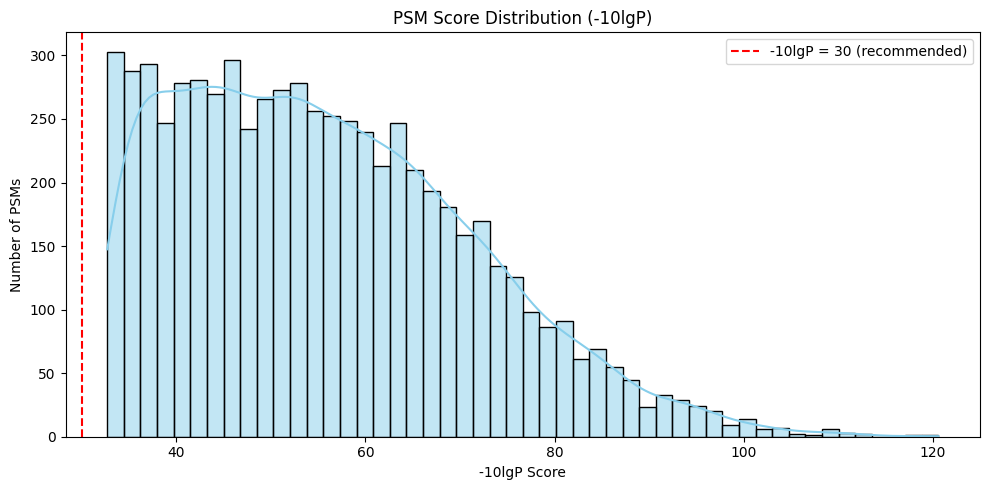

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_distribution(df, score_column="-10lgP", bins=50):
    """
    Visualize the distribution of PSM confidence scores (-10lgP).

    Args:
        df (pd.DataFrame): The PSM DataFrame (can be full or filtered).
        score_column (str): Name of the score column to plot (default is '-10lgP').
        bins (int): Number of histogram bins.
    """
    # === Validation ===
    # Ensure the expected column is present in the input DataFrame
    if score_column not in df.columns:
        raise ValueError(f"'{score_column}' not found in DataFrame.")

    # === Create the plot ===
    plt.figure(figsize=(10, 5))
    
    # Histogram with KDE overlay for score distribution
    sns.histplot(df[score_column], bins=bins, kde=True, color="skyblue")

    # Recommended cutoff line for reference (can be adjusted)
    plt.axvline(30, color="red", linestyle="--", label="-10lgP = 30 (recommended)")

    # Plot labels and aesthetics
    plt.title("PSM Score Distribution (-10lgP)")
    plt.xlabel("-10lgP Score")
    plt.ylabel("Number of PSMs")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualize scores in the filtered PSM set ===
# You may also use `plot_score_distribution(df)` to inspect the unfiltered distribution
plot_score_distribution(filtered_psms)

## Step 4: Peptide Count Summary and Protein Coverage Metrics

After filtering high-confidence PSMs, we perform basic quantitative analysis to evaluate:

- The total number of peptide-spectrum matches (PSMs).
- The number of unique peptide sequences.
- How peptides are distributed across proteins.

These statistics help assess:
- Redundancy in the dataset.
- Protein coverage (especially useful for custom or metagenomic databases).
- Whether certain accessions dominate the match landscape.


In [7]:
# === Basic peptide count metrics ===

# Total number of peptide-spectrum matches (PSMs)
total_psms = len(df)

# Number of unique peptide sequences (ignores multiplicity)
unique_peptides = df["Peptide"].nunique()

# Display summary to console
print(f"Total PSMs: {total_psms}")
print(f"Unique peptides: {unique_peptides}")

# === Optional: Peptide counts per protein accession ===

# Group by accession and count the number of unique peptides per protein
peptides_per_protein = df.groupby("Accession")["Peptide"].nunique()

# Sort proteins by the number of unique peptides assigned (descending order)
peptides_per_protein = peptides_per_protein.sort_values(ascending=False)

# Display the top 10 proteins with highest peptide support
print("\nPeptide counts per protein (top 10):")
print(peptides_per_protein.head(10))



Total PSMs: 6630
Unique peptides: 4545

Peptide counts per protein (top 10):
Accession
A0A935K8M0               24
A0A1W1HWQ2:A0A1W9IXY8    21
A0A935N1A9               21
A0A1W1HWQ2               19
A0A1W1HY98               18
A0A1W1HW58               18
A0A6A7RN62               18
A0A1W1HW58:D8P8B0        17
A0A936H9G0               17
A0A2T5I090               17
Name: Peptide, dtype: int64


## Step 5: Mapping Protein Accessions to Taxonomic Names

To understand the taxonomic identity of peptide-spectrum matches (PSMs), we need to map the protein accessions (from the PSM table) back to their annotated organism names. These names are usually embedded in the headers of the FASTA database used during the search.

### Why this step is important:
- It links database-derived accessions to biological taxa.
- Allows downstream computation of taxonomic composition at various ranks (e.g., genus, species).
- Enables taxonomic annotation of each peptide match.

### How it works:
1. Parse the FASTA file to build an **accession-to-taxon** lookup table.
2. Extract all accessions from each PSM entry.
3. Map them to taxon names using the lookup table.
4. Create a new dataframe with peptide–taxon mappings.


In [9]:
from Bio import SeqIO
from IPython.display import display
import pandas as pd
import re

# === Step 1: Parse your FASTA DB to build accession → (taxon name, taxon ID) lookup ===
fasta_path = r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\pipelines\Diamond_alignments\session_diamond_align_2025-06-08_00-28-56\diamond_proteins_from_proteomes_clustered95_with_metadata.fasta"

# Dictionary: accession → (taxon name, taxon ID)
accession_to_taxa = {}

for record in SeqIO.parse(fasta_path, "fasta"):
    header = record.description

    # Extract taxon name
    name_match = re.search(r"OS=(.+?)(?: OX=| GN=| PE=| SV=|$)", header)
    taxon_name = name_match.group(1).strip() if name_match else "Unknown"

    # Extract taxon ID
    id_match = re.search(r"OX=(\d+)", header)
    taxon_id = id_match.group(1) if id_match else "NA"

    # Map each accession
    for acc in record.id.split("|"):
        accession_to_taxa[acc.strip()] = (taxon_name, taxon_id)

# === Step 2: Extract both name and ID per accession column ===
def extract_taxa_info(accession_str):
    """
    For a given accession field (may contain multiple IDs), return unique taxon names and IDs.
    """
    if pd.isna(accession_str):
        return "", ""
    
    seen_names = set()
    seen_ids = set()
    taxon_names = []
    taxon_ids = []

    for block in accession_str.split(":"):
        for acc in block.split("|"):
            acc = acc.strip()
            name_id = accession_to_taxa.get(acc, ("NA", "NA"))
            if name_id[0] not in seen_names:
                seen_names.add(name_id[0])
                taxon_names.append(name_id[0])
            if name_id[1] not in seen_ids:
                seen_ids.add(name_id[1])
                taxon_ids.append(name_id[1])

    return ", ".join(taxon_names), ", ".join(taxon_ids)

# === Step 3: Apply mapping to DataFrame ===
df_with_taxa = df[["Peptide", "Accession"]].copy()
df_with_taxa[["Taxon names", "Taxon IDs"]] = df_with_taxa["Accession"].apply(
    lambda x: pd.Series(extract_taxa_info(x))
)

# === Step 4: Preview output ===
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

print("\nMapped taxon names and IDs for each PSM:")
display(df_with_taxa.shape)
display(df_with_taxa.head(50))



Mapped taxon names and IDs for each PSM:


(6630, 4)

,Peptide,Accession,Taxon names,Taxon IDs
0,LGEHNIDVLEGNEQFINAAK,NaN,,
1,LGEHNIDVLEGNEQFINAAK,NaN,,
2,LGEHNIDVLEGNEQFINAAK,NaN,,
3,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538
4,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538
5,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538
6,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538
7,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538
8,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538
9,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538


## Step 6: Mapping Scientific Names to NCBI Taxon IDs

To perform lineage lookups or compute the lowest common ancestor (LCA) of PSMs, we must first convert scientific names (from FASTA headers) to **NCBI Taxon IDs**. This allows integration with tools like UniProt, NCBI Taxonomy, or LCA assignment functions.

### Why this step is important:
- Taxon IDs are the universal standard for referencing organisms across databases.
- Many bioinformatics tools (e.g., MEGAN, UniPept) require taxon IDs as input.
- Enables programmatic access to full lineage or taxonomic metadata.

### How it works:
1. Use NCBI Entrez to query each organism name.
2. Retrieve its corresponding taxon ID from the **taxonomy** database.
3. Add a caching mechanism to avoid redundant requests.
4. Apply to each row containing taxon names, which may contain multiple values.

> Note: We respect NCBI rate limits with a small delay per request.


In [ ]:
# Only necessary to run when you need to map taxon IDs from names and could not find them in the FASTA file.
'''
import pandas as pd
import time
import requests
from Bio import Entrez
from IPython.display import display

# === Set email for NCBI Entrez access ===
Entrez.email = "your_email@example.com"

# === Caches for performance ===
taxid_cache = {}
uniprot_retry_count = 3

# === Query UniProt for Taxon ID ===
def get_taxid_from_uniprot(name):
    base_url = "https://rest.uniprot.org/taxonomy/search"
    params = {
        "query": name,
        "fields": "id",
        "format": "tsv",
        "size": 1
    }

    for attempt in range(uniprot_retry_count):
        try:
            response = requests.get(base_url, params=params, timeout=5)
            if response.status_code == 200:
                lines = response.text.strip().split("\n")
                if len(lines) > 1:
                    return lines[1].strip()
            time.sleep(0.5)
        except Exception as e:
            print(f"[UniProt Error] '{name}' (attempt {attempt+1}): {e}")
            time.sleep(0.5)
    return None

# === Query NCBI Entrez for Taxon ID ===
def get_taxid_from_ncbi(name):
    try:
        handle = Entrez.esearch(db="taxonomy", term=name.strip(), retmode="xml")
        records = Entrez.read(handle)
        handle.close()
        if records["IdList"]:
            return records["IdList"][0]
    except Exception as e:
        print(f"[NCBI Error] '{name}': {e}")
    return None

# === Full fallback function ===
def get_taxid(name):
    if pd.isna(name):
        return "NA"

    if name in taxid_cache:
        return taxid_cache[name]

    taxid = get_taxid_from_uniprot(name)
    if not taxid:
        taxid = get_taxid_from_ncbi(name)
        time.sleep(0.35)  # NCBI rate limit

    taxid_cache[name] = taxid if taxid else "NA"
    return taxid_cache[name]

# === Apply to column with multiple names per row ===
def extract_taxids(taxon_str):
    if pd.isna(taxon_str):
        return ""
    names = [n.strip() for n in taxon_str.split(",") if n.strip()]
    taxids = [get_taxid(name) for name in names]
    return ", ".join(taxids)

# === Apply to DataFrame ===
df_with_taxa["Taxon IDs"] = df_with_taxa["Taxon names"].apply(extract_taxids)

# === Summary statistics ===
total = df_with_taxa.shape[0]
mapped = df_with_taxa["Taxon IDs"].apply(lambda x: x != "" and "NA" not in x).sum()

print(f"\nTaxon ID mapping complete.")
print(f"Matched: {mapped} / {total} peptides ({mapped / total:.1%})")

# === Preview result ===
display(df_with_taxa[["Peptide", "Accession", "Taxon names", "Taxon IDs"]].head(15))
'''



✅ Taxon ID mapping complete.
Matched: 5247 / 5524 peptides (95.0%)


,Peptide,Accession,Taxon names,Taxon IDs
0,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
1,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
2,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
3,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
4,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
5,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
6,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
7,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
8,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160
9,YGVGANYANGPINVDLVYQGR,A0A369XSR1,Candidatus Accumulibacter phosphatis,327160


## Step 7: Inferring the Lowest Common Ancestor (LCA)

To summarize the taxonomic identity of each PSM or peptide, we determine the **Lowest Common Ancestor (LCA)** from all matched taxa. This gives a single representative organism and its rank for downstream profiling.

### Why this step is important:
- Aggregates multiple potential taxon hits into a single, biologically interpretable consensus.
- Facilitates genus- or species-level community composition plots.
- Makes it easier to compare different protein databases or peptide sets.

### How it works:
1. Each peptide (or PSM) may map to multiple taxon IDs.
2. We use the [UniPept taxa2lca API](https://unipept.ugent.be/apidocs#taxa2lca) to compute the LCA across those IDs.
3. If only one taxon is provided, it is used as the exact match.
4. For each peptide, the resulting LCA name and its taxonomic rank are stored.


In [10]:
import requests
import pandas as pd

# === Step 1: Define LCA fetch function using UniPept API ===
def get_lca_and_rank(taxon_ids_str):
    """
    Given a comma-separated list of taxon IDs, query UniPept to get their Lowest Common Ancestor (LCA).

    Args:
        taxon_ids_str (str): Taxon IDs as comma-separated string (e.g., "562,561")

    Returns:
        pd.Series: [LCA name, LCA rank] or ["NA", "NA"] on failure
    """
    try:
        # Clean and split taxon ID string
        taxon_ids = [tid.strip().strip("\"'") for tid in taxon_ids_str.split(",") if tid.strip()]
        
        if not taxon_ids:
            return pd.Series(["NA", "NA"])

        if len(taxon_ids) == 1:
            # Only one match, treat it as exact organism
            return pd.Series([taxon_ids[0], "exact match"])

        # === Step 2: Build API query ===
        params = "&".join([f"input[]={tid}" for tid in taxon_ids])
        url = f"https://api.unipept.ugent.be/api/v2/taxa2lca.json?{params}&extra=true"
        
        # === Step 3: Query UniPept ===
        response = requests.get(url)
        response.raise_for_status()
        result = response.json()

        # === Step 4: Parse response ===
        if isinstance(result, dict):
            return pd.Series([result.get("taxon_name", "NA"), result.get("taxon_rank", "NA")])
        elif isinstance(result, list) and result:
            return pd.Series([result[0].get("taxon_name", "NA"), result[0].get("taxon_rank", "NA")])
        else:
            return pd.Series(["NA", "NA"])

    except Exception as e:
        print(f"Error retrieving LCA for taxon IDs {taxon_ids}: {e}")
        return pd.Series(["NA", "NA"])

# === Step 5: Apply LCA function to each row ===
df_with_lca = df_with_taxa.copy()
df_with_lca[["lca", "lca rank"]] = df_with_lca["Taxon IDs"].dropna().apply(get_lca_and_rank)

# === Step 6: Display preview ===
display(df_with_lca.shape)
display(df_with_lca[["Peptide", "Accession", "Taxon names", "Taxon IDs", "lca", "lca rank"]].head(50))


(6630, 6)

,Peptide,Accession,Taxon names,Taxon IDs,lca,lca rank
0,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
1,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
2,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
3,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538,2053538,exact match
4,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538,2053538,exact match
5,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538,2053538,exact match
6,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538,2053538,exact match
7,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538,2053538,exact match
8,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538,2053538,exact match
9,KVSYVLPAGSYAVGAGVYDDTPVATLESK,A0A936H9G0,Candidatus Competibacteraceae bacterium,2053538,2053538,exact match


## Step 8: Refining LCA Names for Single-Taxon Hits

When only a **single taxon ID** is associated with a peptide (i.e., no ambiguity), we can **replace the generic LCA output** (e.g., a taxon ID) with the actual organism name from the FASTA headers.

### Why this step is needed:
- The UniPept LCA function returns just the taxon ID as the LCA when there is only one ID.
- This taxon ID is less informative than the scientific name we already extracted from the FASTA header.
- Replacing the LCA with the original **scientific name** provides better readability and interpretation in composition plots.

### What this step does:
- For all rows where there is exactly **one valid taxon ID** (not a list, not NA), we replace the LCA field with the taxon name.
- This only affects **unambiguous matches**, and all multi-hit LCAs remain unchanged.


In [11]:
# Update LCA name for rows with a single taxon ID (skip rows with ',' or empty/NA)
def update_lca_name_if_single(row):
    taxid = row.get("Taxon IDs", "")
    if isinstance(taxid, str) and "," not in taxid and taxid.strip() and taxid.strip().upper() != "NA":
        return row.get("Taxon names", row["lca"])  # use taxon name if available
    return row["lca"]  # keep existing lca for multiple IDs

# Apply to df_with_lca
df_with_lca["lca"] = df_with_lca.apply(update_lca_name_if_single, axis=1)
display(df_with_lca.shape)
display(df_with_lca[["Peptide", "Taxon names", "Taxon IDs", "lca", "lca rank"]].head(50))

(6630, 6)

,Peptide,Taxon names,Taxon IDs,lca,lca rank
0,LGEHNIDVLEGNEQFINAAK,,,NA,NA
1,LGEHNIDVLEGNEQFINAAK,,,NA,NA
2,LGEHNIDVLEGNEQFINAAK,,,NA,NA
3,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,exact match
4,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,exact match
5,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,exact match
6,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,exact match
7,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,exact match
8,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,exact match
9,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,exact match


## Step 9: Correcting the Taxonomic Rank for Single-Taxon Matches

The previous LCA step provides both taxon names and taxonomic ranks. However, when only a **single taxon ID** is matched, UniPept's `taxa2lca` output often returns `"exact match"` as the rank, which is not very informative.

### Why use `taxa2tree`:
- `taxa2tree` returns the **full taxonomic lineage** of a taxon ID.
- We can traverse the resulting tree to extract the actual **rank** of the matched taxon (e.g., *species*, *genus*, *family*).
- This enhances clarity when visualizing taxonomic compositions by consistent rank levels.

### What this step does:
- For each peptide with a single taxon ID, we query `taxa2tree` to get the correct rank of the taxon.
- All multi-hit or ambiguous LCA ranks are left untouched.

### Benefit:
This step ensures **taxonomic consistency** across peptides and databases, especially useful when grouping or comparing taxonomic ranks (e.g., genus-level vs. species-level).


In [12]:
import requests
import pandas as pd

# === Step 9: Correct taxonomic rank for single-taxon matches ===

# Create a working copy
df_with_final_ranks = df_with_lca.copy()

# === Helper function to fetch the taxonomic rank from taxa2tree ===
def fetch_rank_from_taxa2tree(taxon_id):
    """
    Use UniPept taxa2tree API to fetch the actual rank of a given taxon ID.

    Args:
        taxon_id (str): NCBI taxon ID

    Returns:
        str: Taxonomic rank (e.g., 'species', 'genus') or 'NA' if not found
    """
    try:
        # Validate input
        if not taxon_id or not taxon_id.strip().isdigit():
            raise ValueError("Invalid taxon ID")

        # Build the request
        url = "https://api.unipept.ugent.be/api/v2/taxa2tree.json"
        params = {"input[]": taxon_id}
        response = requests.get(url, params=params)
        response.raise_for_status()
        result = response.json()

        # Search the resulting tree recursively for the input taxon ID
        def find_node_rank(node):
            if isinstance(node, dict):
                if node.get("id") == int(taxon_id):
                    return node.get("rank", "NA")
                for child in node.get("children", []):
                    rank = find_node_rank(child)
                    if rank:
                        return rank
            return None

        return find_node_rank(result) or "NA"

    except Exception as e:
        print(f"Error retrieving rank for taxon ID {taxon_id!r}: {e}")
        return "NA"

# === Apply rank update only for single-ID hits ===
def update_rank_if_single(row):
    """
    Update the LCA rank with the actual rank if only a single taxon ID is assigned.

    Args:
        row (pd.Series): Row from DataFrame

    Returns:
        str: Updated or existing rank
    """
    taxid = row.get("Taxon IDs", "").strip()
    if isinstance(taxid, str) and "," not in taxid and taxid.isdigit():
        return fetch_rank_from_taxa2tree(taxid)
    return row["lca rank"]  # Leave existing rank as-is

# Apply across DataFrame
df_with_final_ranks["lca rank"] = df_with_final_ranks.apply(update_rank_if_single, axis=1)

# Preview updated result
display(df_with_final_ranks.shape)
display(df_with_final_ranks[["Peptide", "Taxon names", "Taxon IDs", "lca", "lca rank"]].head(50))


(6630, 6)

,Peptide,Taxon names,Taxon IDs,lca,lca rank
0,LGEHNIDVLEGNEQFINAAK,,,NA,NA
1,LGEHNIDVLEGNEQFINAAK,,,NA,NA
2,LGEHNIDVLEGNEQFINAAK,,,NA,NA
3,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,species
4,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,species
5,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,species
6,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,species
7,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,species
8,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,species
9,KVSYVLPAGSYAVGAGVYDDTPVATLESK,Candidatus Competibacteraceae bacterium,2053538,Candidatus Competibacteraceae bacterium,species


## Step 10: Save Annotated PSM Table for Reuse

After appending taxonomic names, taxon IDs, LCA results, and corrected rank information to each peptide-spectrum match (PSM), we export the resulting annotated DataFrame to a `.csv` file.

### Purpose:
This step **does not continue the biological pipeline**, but ensures that the enriched data can be:
- Reused across different analysis notebooks.
- Easily loaded without repeating time-consuming API calls (e.g., NCBI or UniPept).
- Used for plotting taxonomic compositions across different rank levels.

### Output Location:
The file is saved to:  
`../Community_comparisons/genus_composition_psm.csv`

This makes the file accessible for genus-level bar plots or comparisons between pipelines using different custom databases.


In [13]:

# Define the output path
output_path = Path("../Community_comparisons/diamond_from_proteomes_clust95_psm.csv")

# Create the directory if it doesn't exist
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save the DataFrame to CSV
df_with_final_ranks.to_csv(output_path, index=False)

print(f"Saved to: {output_path.resolve()}")


Saved to: C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\Community_comparisons\diamond_from_proteomes_clust95_psm.csv


## Step 11: Summary of Taxonomic Annotation Coverage

Before proceeding with downstream taxonomic composition analysis, we assess how many peptide-spectrum matches (PSMs) were successfully annotated with:

- At least one valid **Taxon ID** (from NCBI).
- A valid **LCA rank** (Lowest Common Ancestor level, derived from UniPept).

This step is useful to:
- Evaluate annotation success rate of your custom database.
- Compare the richness or annotation quality between multiple databases.
- Diagnose any issues with taxon extraction or mapping.

### Output:
A printed summary of:
- Total number of PSMs.
- Count and percentage of rows with valid taxon IDs.
- Count and percentage of rows with LCA rank assignments.


In [14]:
# === Step 11: Summary statistics of annotation ===

# Check which rows have a non-empty and non-"NA" Taxon ID
has_taxon_id = df_with_final_ranks["Taxon IDs"].apply(
    lambda x: isinstance(x, str) and x.strip() != "" and x.strip().upper() != "NA"
)
n_with_taxon_id = has_taxon_id.sum()

# Check which rows have a non-empty and non-"NA" LCA rank
has_lca_rank = df_with_final_ranks["lca rank"].apply(
    lambda x: isinstance(x, str) and x.strip().upper() != "NA"
)
n_with_lca_rank = has_lca_rank.sum()

# Get total number of PSMs
total_rows = len(df_with_final_ranks)

# === Display results ===
print("Taxonomic summary:")
print(f"- Total rows: {total_rows}")
print(f"- Rows with Taxon ID: {n_with_taxon_id}")
print(f"- Rows with LCA rank: {n_with_lca_rank}")
print(f"- % with Taxon ID: {n_with_taxon_id / total_rows:.2%}")
print(f"- % with LCA rank: {n_with_lca_rank / total_rows:.2%}")


Taxonomic summary:
- Total rows: 6630
- Rows with Taxon ID: 6382
- Rows with LCA rank: 6382
- % with Taxon ID: 96.26%
- % with LCA rank: 96.26%


## Step 12: Distribution of PSMs Across Taxonomic Ranks

After assigning a Lowest Common Ancestor (LCA) to each peptide-spectrum match (PSM), it's useful to examine how many matches were resolved at different taxonomic levels. This can reveal:

- The **depth of resolution** your database supports (e.g., strain-level vs. genus-level).
- Which taxonomic ranks dominate your annotations.
- Whether further filtering or taxonomic collapsing is needed in downstream analysis.

Here, we inspect a few relevant ranks:
- Strain
- Species
- Genus
- Family

This allows us to summarize the **taxonomic precision** of the matched database.


In [15]:
# === Step 12: Count PSMs per LCA rank ===

# Define which taxonomic ranks we care about in the summary
ranks_of_interest = ["strain", "species", "genus", "family"]

# Count the frequency of each rank label across all annotated PSMs
rank_counts = df_with_final_ranks["lca rank"].value_counts()

# Extract the count for only our ranks of interest (defaults to 0 if not found)
psm_counts_per_rank = {rank: rank_counts.get(rank, 0) for rank in ranks_of_interest}

# Print the formatted summary
print("Number of PSMs per taxonomic rank:")
for rank, count in psm_counts_per_rank.items():
    print(f"- {rank.title()}: {count} PSMs")


Number of PSMs per taxonomic rank:
- Strain: 349 PSMs
- Species: 4312 PSMs
- Genus: 878 PSMs
- Family: 43 PSMs


## Step 13: Plot Microbial Composition per Taxonomic Rank

Now that each PSM has an assigned Lowest Common Ancestor (LCA) and taxonomic rank, we can visualize the microbial composition across selected ranks.

This step:
- Filters PSMs for each specified rank (e.g., genus, species, strain).
- Calculates **relative abundances** of taxon names within that rank.
- Plots a **bar chart** per rank to highlight the most represented taxa.

This helps us understand:
- The **dominant organisms** at each rank level.
- How taxonomic resolution influences interpretation.
- Whether taxonomic collapsing or deeper analysis is required in future steps.

**Ranks visualized:** `"strain"`, `"species"`, `"genus"`, `"family"`


C:\Temp\ipykernel_29148\1455379800.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))


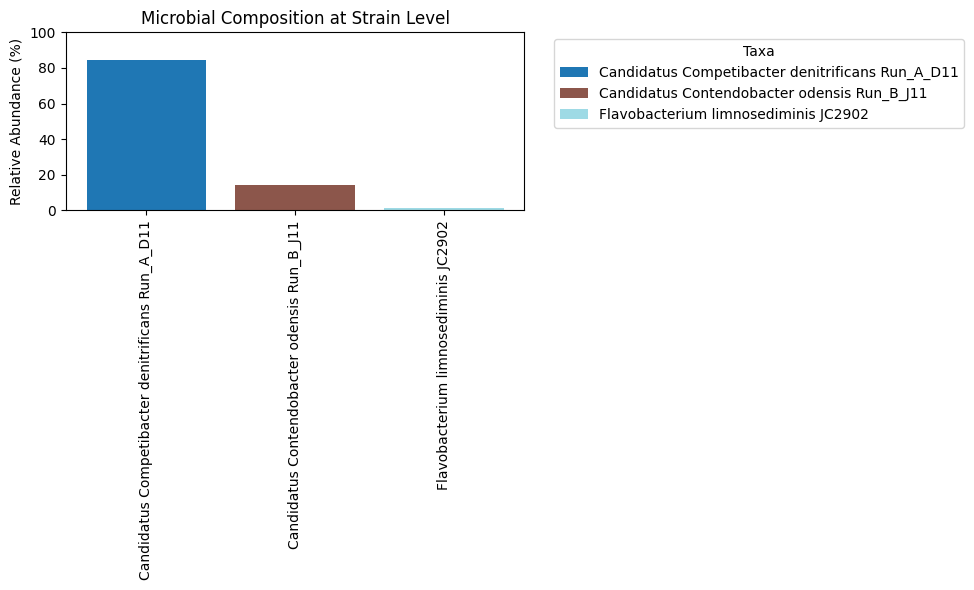

C:\Temp\ipykernel_29148\1455379800.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))


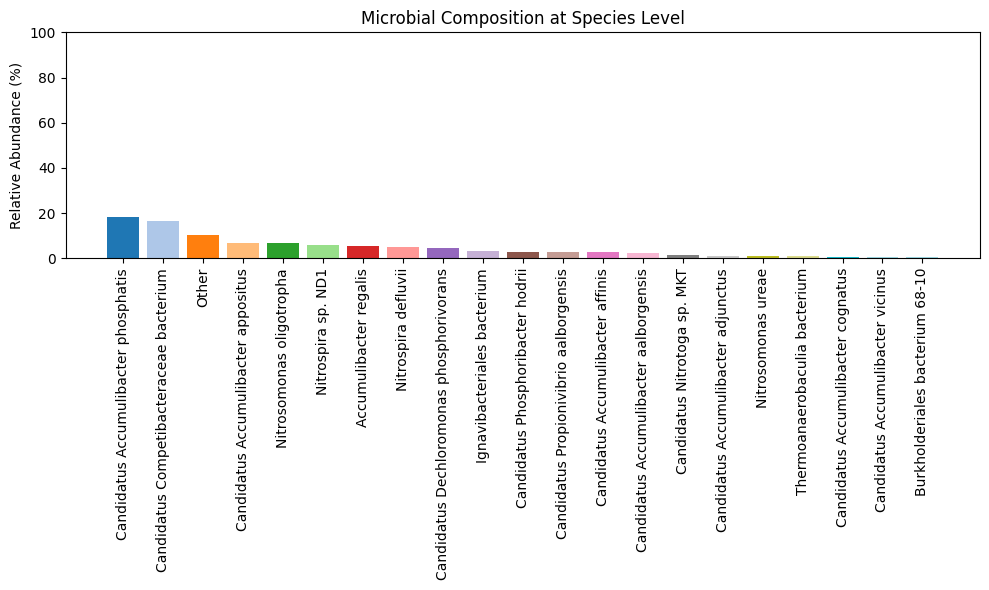

C:\Temp\ipykernel_29148\1455379800.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))


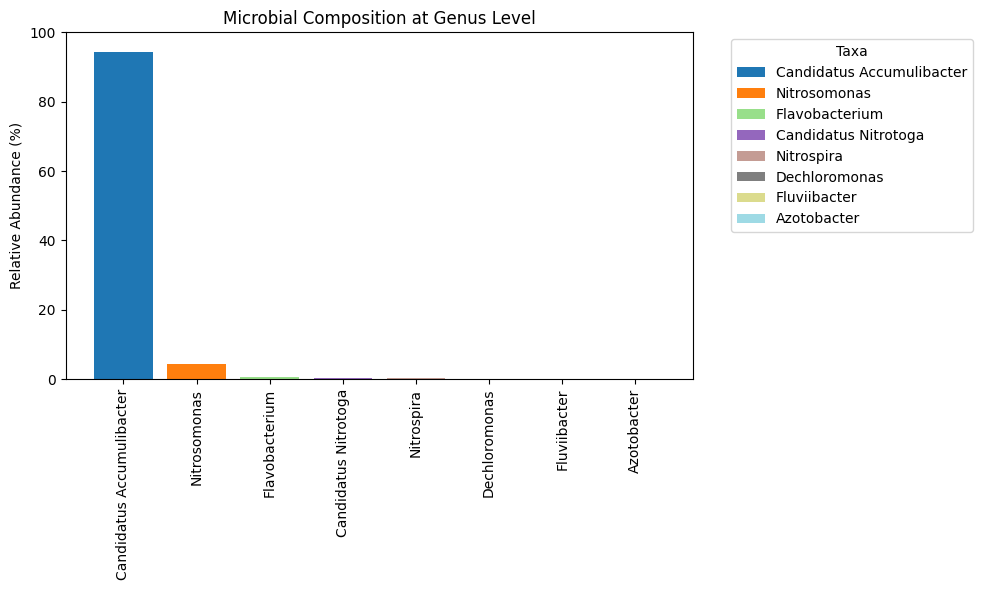

C:\Temp\ipykernel_29148\1455379800.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))


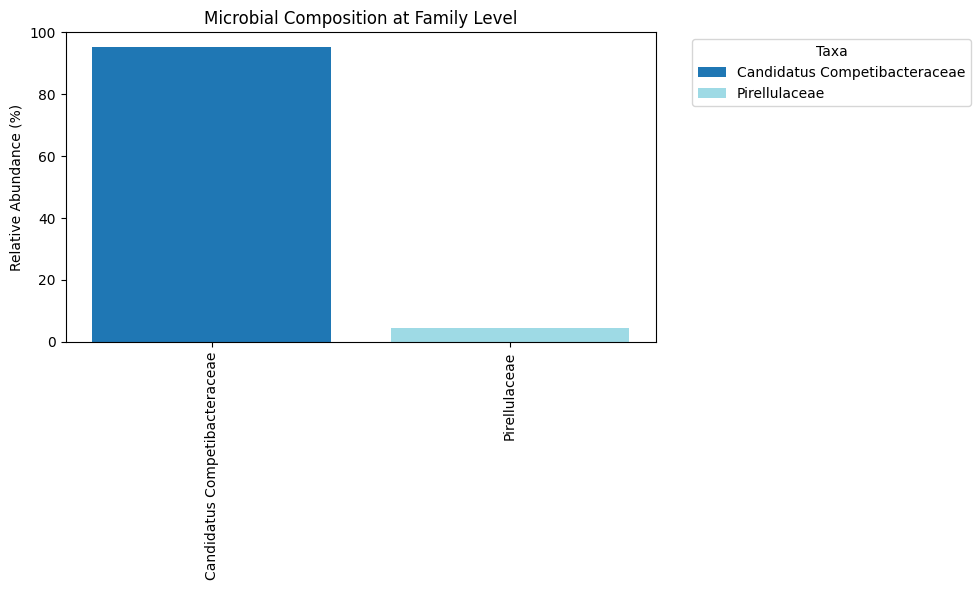

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# === Step: Define settings ===
ranks_to_plot = ["strain", "species", "genus", "family"]
top_n = 20               # Number of top taxa to plot
include_other = True     # Whether to group remaining taxa as "Other"

# === Step: Plot microbial composition per rank ===
for rank in ranks_to_plot:
    rank_df = df_with_final_ranks[df_with_final_ranks["lca rank"] == rank]

    if rank_df.empty:
        print(f"No data for rank: {rank}")
        continue

    # Count frequency of each LCA taxon
    taxon_counts = rank_df["lca"].value_counts()
    total_count = taxon_counts.sum()

    # Split top N and "Other"
    top_taxa = taxon_counts.head(top_n)
    other_count = total_count - top_taxa.sum()

    if include_other and other_count > 0:
        top_taxa["Other"] = other_count

    # Compute relative abundance
    rel_abundance = (top_taxa / total_count) * 100
    rel_abundance = rel_abundance.sort_values(ascending=False)

    # Color map for bars
    cmap = cm.get_cmap('tab20', len(rel_abundance))
    colors = [cmap(i) for i in range(len(rel_abundance))]

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.bar(rel_abundance.index, rel_abundance.values, color=colors)

    plt.xticks(rotation=90)
    plt.ylabel("Relative Abundance (%)")
    plt.title(f"Microbial Composition at {rank.title()} Level")
    plt.ylim(0, 100)

    # Optional: legend
    if len(rel_abundance) <= 20:
        plt.legend(bars, rel_abundance.index, title="Taxa", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


### Comparison of Taxonomic Profiles: De Novo vs. PSM-Based

Interestingly, the microbial composition based on matched peptide spectrum matches (PSMs) revealed **more species** than the earlier de novo peptide-based analysis, yet **fewer genera**.

This likely reflects the impact of the **custom protein database filtering strategy**. The database was constructed by selecting proteins based on their genus-level annotations, which limits the number of genera detectable post-database. However, within each retained genus, the FASTA headers often still contain **species-level annotations**, allowing finer taxonomic resolution during downstream mapping.

In contrast, the de novo-based approach (e.g., via UniPept) likely explored a **broader range of genera** — including low-abundance or low-confidence matches — resulting in **greater genus-level diversity** but less certainty at finer resolutions.

Thus, the observed difference suggests that PSM-based profiles are **more taxonomically precise** (especially at the species level) but **constrained by the original database scope**, particularly at higher taxonomic ranks.

For future iterations, using a broader taxonomic filter (e.g., including families or all genera above a certain confidence) may help preserve community diversity while retaining annotation depth.


### Should Microbial Composition Be Area-Weighted?

While peptide-spectrum match (PSM) counts provide a basic estimate of microbial presence, they do not reflect the **abundance** or **intensity** of those peptides. By weighting taxa by the **chromatographic area** of their matched peptides, we obtain a more **quantitative estimate of taxon abundance**.

This approach accounts for both the number and intensity of matched peptides, offering a closer proxy to actual protein expression or biomass contributions. Therefore, area-weighted microbial profiles can be considered more biologically meaningful than simple PSM counts.

In [ ]:
# Sanity check: Are both dataframes aligned row-by-row?
assert df_with_final_ranks.shape[0] == df.shape[0], "Mismatch in rows! Cannot align safely."

# Copy the original taxonomic dataframe
df_ranks_with_area = df_with_final_ranks.copy()

# Directly assign the Area column from df (same order assumed)
df_ranks_with_area["Area"] = df["Area"].values

# Check result
print("Successfully aligned Area values row-by-row.")
display(df_ranks_with_area.shape)
display(df_ranks_with_area[["Peptide", "Area"]].head(10))


✅ Successfully aligned Area values row-by-row.


(6335, 7)

,Peptide,Area
0,LGEHNIDVLEGNEQFINAAK,754000.0
1,LGEHNIDVLEGNEQFINAAK,18576000.0
2,LGEHNIDVLEGNEQFINAAK,18576000.0
3,KVQAAQYVASHPGEVC(+57.02)PAK,5418600.0
4,KVQAAQYVASHPGEVC(+57.02)PAK,5364300.0
5,YGVGANYANGPINVDLVYQGR,12892000.0
6,YGVGANYANGPINVDLVYQGR,12892000.0
7,YGVGANYANGPINVDLVYQGR,12892000.0
8,YGVGANYANGPINVDLVYQGR,12892000.0
9,YGVGANYANGPINVDLVYQGR,12892000.0


C:\Temp\ipykernel_21836\408833064.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))


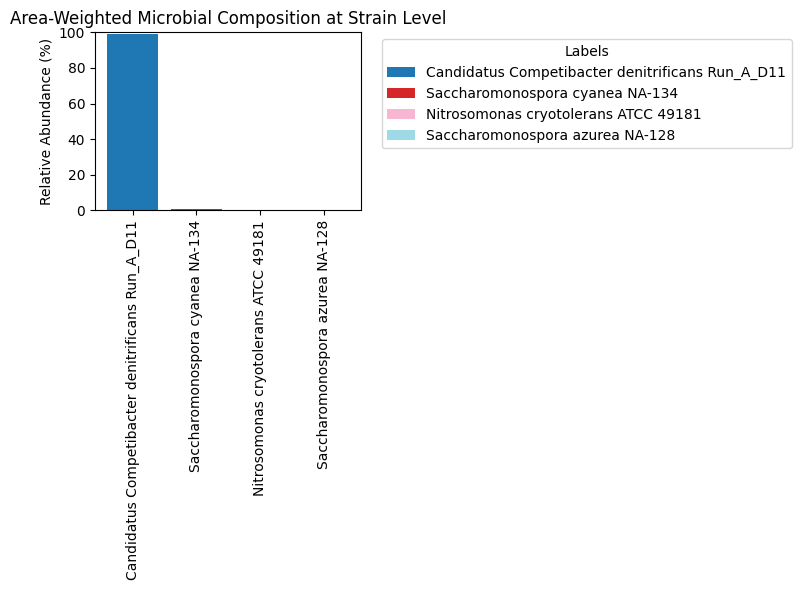

C:\Temp\ipykernel_21836\408833064.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))
C:\Temp\ipykernel_21836\408833064.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


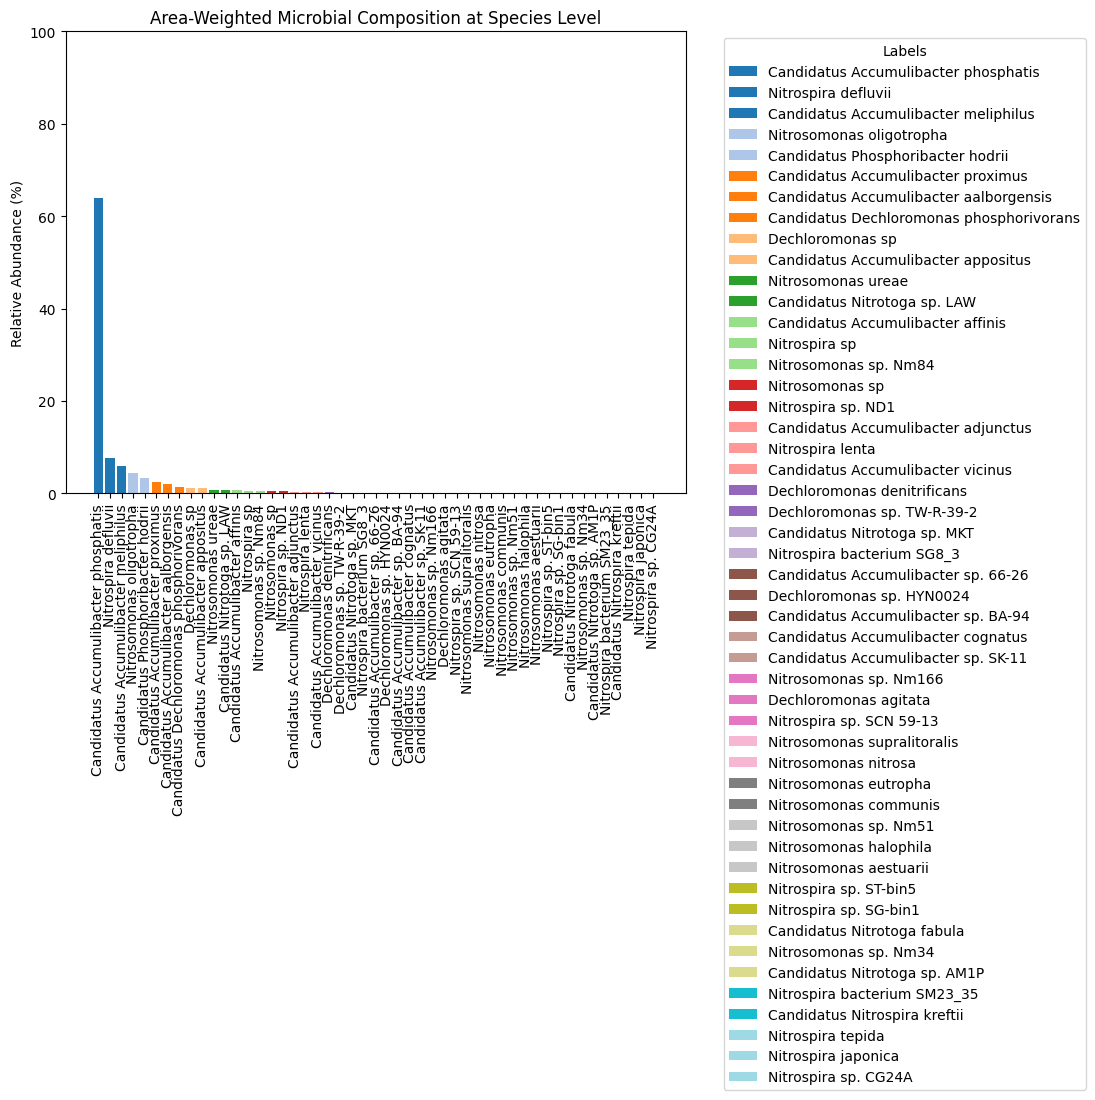

C:\Temp\ipykernel_21836\408833064.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))


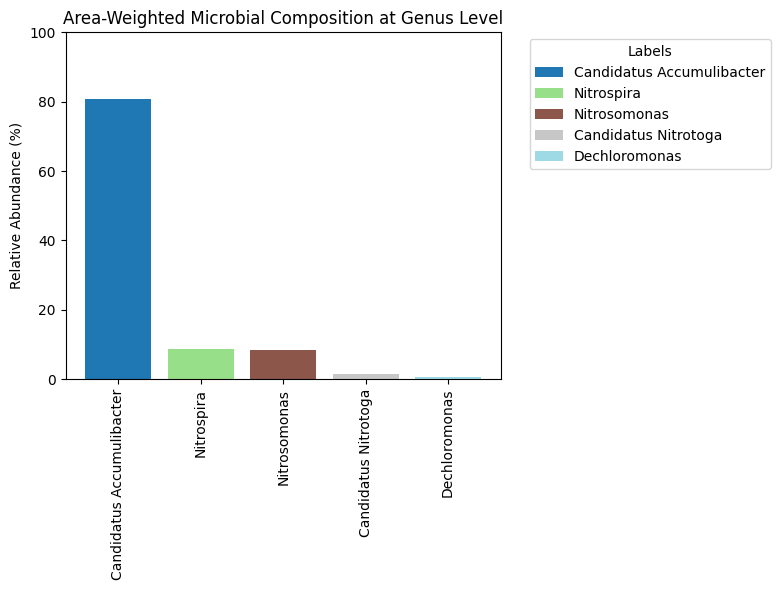

⚠️ No area data or no PSMs for rank: family


In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Ranks to visualize
ranks_to_plot = ["strain", "species", "genus", "family"]

for rank in ranks_to_plot:
    # Filter PSMs with this rank
    rank_df = df_ranks_with_area[df_ranks_with_area["lca rank"] == rank]

    if rank_df.empty or "Area" not in rank_df.columns:
        print(f"⚠️ No area data or no PSMs for rank: {rank}")
        continue

    # Group by LCA taxon name and sum area values
    taxon_abundance = rank_df.groupby("lca")["Area"].sum()
    taxon_abundance = taxon_abundance[taxon_abundance > 0]  # remove zero areas
    rel_abundance = (taxon_abundance / taxon_abundance.sum()) * 100
    rel_abundance = rel_abundance.sort_values(ascending=False)

    # Generate unique colors
    cmap = cm.get_cmap('tab20', len(rel_abundance))
    colors = [cmap(i) for i in range(len(rel_abundance))]

    # Plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(rel_abundance.index, rel_abundance.values, color=colors)

    plt.xticks(rotation=90)
    plt.ylabel("Relative Abundance (%)")
    plt.title(f"Area-Weighted Microbial Composition at {rank.title()} Level")
    plt.ylim(0, 100)
    plt.legend(bars, rel_abundance.index, title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


### Comparison of Microbial Community Composition: Unweighted vs. Area-Weighted

#### Overview
To accurately interpret the microbial composition of the sample, we compared two approaches:

1. **Unweighted Composition** – based purely on the frequency of peptide-spectrum matches (PSMs) associated with each taxon in the `df_with_final_ranks` dataframe.
2. **Area-Weighted Composition** – based on the summed ion intensity (*Area*) values per taxon, which account for the abundance of the detected peptides.

Both methods were applied across four taxonomic ranks: **strain**, **species**, **genus**, and **family**. Below we discuss the key findings and differences observed in the results.

---

#### Key Observations

##### **1. Strain Level**
- **Unweighted**: Candidatus *Competibacter denitrificans Run_A_D11* dominated the community by count, with minimal representation of other strains.
- **Area-Weighted**: The dominance of *Competibacter denitrificans* became even more pronounced (>90%), while low-abundance strains were further diminished.
- **Conclusion**: Ion intensity confirmed that the high detection count of this strain was supported by its strong signal intensity, indicating a truly dominant presence.

---

##### **2. Species Level**
- **Unweighted**: The community showed a diverse profile, with species like *Candidatus Accumulibacter phosphatis*, *Nitrospira defluvii*, and *Nitrosomonas oligotropha* being frequently detected.
- **Area-Weighted**: While the same species remained dominant, *Candidatus Accumulibacter phosphatis* became significantly more dominant (~65% relative abundance), suggesting it produces highly abundant peptides.
- **Conclusion**: Many rare species by count contributed relatively little in signal intensity, highlighting that frequency alone may overestimate their biological relevance.

---

##### **3. Genus Level**
- **Unweighted**: A relatively diverse genus-level composition was observed, including *Candidatus Accumulibacter*, *Nitrosomonas*, *Nitrospira*, and others.
- **Area-Weighted**: The profile remained similar but became slightly more skewed toward *Accumulibacter*, consistent with the species-level findings.
- **Conclusion**: Genera with more abundant peptides gained weight, emphasizing that signal strength refines genus-level abundance estimations.

---


#### Summary

| Metric                | Unweighted Results                                   | Area-Weighted Results                                       |
|----------------------|------------------------------------------------------|-------------------------------------------------------------|
| Dominant Strain       | *Competibacter denitrificans*                        | *Competibacter denitrificans* (more pronounced)             |
| Species Diversity     | Moderate to high (based on detection count)          | Lower (dominated by species with high signal intensity)     |
| Genus Composition     | Balanced among top genera                            | Still diverse but more skewed toward abundant organisms     |
| Sensitivity to Noise  | Higher (equal weight to all identifications)         | Lower (de-emphasizes weak/noisy matches)                    |

---

#### Interpretation Tip:
> While unweighted compositions reflect detection breadth (how many different organisms were picked up), **area-weighted** compositions better approximate the **biological abundance** of organisms in the sample, especially in LC-MS/MS workflows where ion intensity is a proxy for peptide/protein quantity.


